In [1]:
import boto3
import pandas as pd
from datetime import datetime
import numpy as np
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.feature_selection import RFECV

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
# import mlflow
# import mlflow.pytorch

import warnings
warnings.filterwarnings("ignore")

# 0. Leitura dos Dados

In [2]:
config_classifier = yaml.safe_load(open('config_classifier.yaml', 'rb'))

In [3]:
config_classifier

{'bucket_name': 'fiap-projeto-math-refined',
 'path_file_name': 'bitcoin/part-00000-a456c75c-7ccc-4db5-bd30-c4d135abc456-c000.snappy.parquet',
 'generate_new_model': False,
 'params': {'boosting_type': 'gbdt',
  'class_weight': None,
  'colsample_bytree': 1.0,
  'importance_type': 'split',
  'learning_rate': 0.01,
  'max_depth': -1,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'min_split_gain': 0.0,
  'n_estimators': 358,
  'n_jobs': -1,
  'num_leaves': 31,
  'objective': 'binary',
  'random_state': 42,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'subsample': 1.0,
  'subsample_for_bin': 200000,
  'subsample_freq': 0},
 'run_selector': False,
 'vars': ['Volume',
  'log_return_1d',
  'zscore_7',
  'rolling_std_30',
  'momentum_3d',
  'rsi_14']}

## 0.1 Extraindo Dados do S3

In [4]:
extract_table = False
if extract_table:
    client = boto3.client('s3')
    client.download_file(Bucket='fiap-projeto-math-refined', Key=config_classifier['path_file_name'], Filename='file.snappy.parquet')

In [5]:
# Carregar dados (ajuste o caminho do arquivo)
df = pd.read_parquet('file.snappy.parquet')

In [6]:
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()

In [7]:
df.sample()[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].to_json(orient='records')

'[{"Date":"2021-06-10 00:00:00","Open":37389.515625,"High":38334.32421875,"Low":35847.59375,"Close":36702.59765625,"Volume":43576032854}]'

In [8]:
df.Date.max()

'2025-05-05 00:00:00'

# 1. Processamento dos Dados

In [9]:
def generate_features(df):
    df = df.copy()

    df.sort_values("Date", inplace=True)
    df.reset_index(drop=True, inplace=True)
    

    # features baseadas em janelas de tempo
    df['log_return_1d'] = np.log(df['Close'] / df['Close'].shift(1))
    for win in [7, 30, 90, 180]:
        df[f'rolling_mean_{win}'] = df['Close'].rolling(win).mean()
        df[f'rolling_std_{win}'] = df['Close'].rolling(win).std()
        df[f'rolling_max_{win}'] = df['Close'].rolling(win).max()
        df[f'rolling_min_{win}'] = df['Close'].rolling(win).min()
        df[f'zscore_{win}'] = (df['Close'] - df[f'rolling_mean_{win}']) / (df[f'rolling_std_{win}'] + 1e-9)

    # features baseadas em momento de mercado
    df['momentum_3d'] = df['Close'] - df['Close'].shift(3)
    df['momentum_7d'] = df['Close'] - df['Close'].shift(7)

    # features baseadas em RSI (sugestão do chatGPT) em uma janela de 14 dias.
    #O RSI varia entre 0 e 100, e indica:
     #   RSI > 70 → ativo sobrecomprado - pode indicar que o preço vai corrigir para baixo
     #   RSI < 30 → ativo sobrevendido - pode indicar que o preço vai subir em breve
     #   RSI entre 30 e 70 → zona neutra.
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    df['rsi_14'] = 100 - (100 / (1 + rs))

    # janela móvel do volume dos ultimos 7 dias
    df['volume_mean_7'] = df['Volume'].rolling(7).mean()

    #A variável volume_spike mede o quanto o volume negociado em um dia está acima ou abaixo da média recente — ou seja, ela identifica “picos” (spikes) ou quedas de volume.
    df['volume_spike'] = df['Volume'] / (df['volume_mean_7'] + 1e-9)

    #A variável position_in_range_30 indica onde o preço de fechamento do dia atual está localizado dentro da faixa dos últimos 30 dias.
    df['position_in_range_30'] = (df['Close'] - df['rolling_min_30']) / (df['rolling_max_30'] - df['rolling_min_30'] + 1e-9)

    # Remover colunas temporárias e dados NA
    df.drop(columns=['volume_mean_7'], inplace=True)
    df.dropna(inplace=True)

    return df

In [10]:
# Gerar features e target
df = generate_features(df)

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ========================
# 1. Carregamento do Dataset
# ========================
# df = pd.read_excel("/mnt/data/tabela_processada.xlsx")  # ou pd.read_csv()

target_column = 'Close'
features = df.drop(['Date', 'Close'], axis=1).columns.tolist()

X_raw = df[features].copy()
y_raw = df[[target_column]].copy()

In [12]:
# ========================
# 2. Normalização
# ========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit(X_raw)
y_scaled = scaler_y.fit(y_raw)

X_scaled = scaler_X.transform(X_raw)
y_scaled = scaler_y.transform(y_raw)

In [13]:
# ========================
# 3. Criar janelas sequenciais
# ========================
def create_sequences(X, y, window):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

window_size = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

In [14]:
# ========================
# 4. Treino / Validação
# ========================
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [15]:
# ========================
# 5. Dataset e DataLoader
# ========================
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=batch_size)

In [16]:
# ========================
# 6. Modelo LSTM para Regressão
# ========================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [17]:
# ========================
# 7. Treinamento
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = X_seq.shape[2]
hidden_size = 200
num_layers = 2
output_size = 1
learning_rate = 0.0001
num_epochs = 100

model = LSTMRegressor(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/100], Loss: 0.0991
Epoch [2/100], Loss: 0.0210
Epoch [3/100], Loss: 0.0142
Epoch [4/100], Loss: 0.0116
Epoch [5/100], Loss: 0.0100
Epoch [6/100], Loss: 0.0094
Epoch [7/100], Loss: 0.0088
Epoch [8/100], Loss: 0.0088
Epoch [9/100], Loss: 0.0087
Epoch [10/100], Loss: 0.0082
Epoch [11/100], Loss: 0.0081
Epoch [12/100], Loss: 0.0082
Epoch [13/100], Loss: 0.0080
Epoch [14/100], Loss: 0.0075
Epoch [15/100], Loss: 0.0078
Epoch [16/100], Loss: 0.0077
Epoch [17/100], Loss: 0.0076
Epoch [18/100], Loss: 0.0071
Epoch [19/100], Loss: 0.0074
Epoch [20/100], Loss: 0.0071
Epoch [21/100], Loss: 0.0074
Epoch [22/100], Loss: 0.0068
Epoch [23/100], Loss: 0.0068
Epoch [24/100], Loss: 0.0068
Epoch [25/100], Loss: 0.0071
Epoch [26/100], Loss: 0.0067
Epoch [27/100], Loss: 0.0069
Epoch [28/100], Loss: 0.0066
Epoch [29/100], Loss: 0.0066
Epoch [30/100], Loss: 0.0068
Epoch [31/100], Loss: 0.0065
Epoch [32/100], Loss: 0.0066
Epoch [33/100], Loss: 0.0064
Epoch [34/100], Loss: 0.0062
Epoch [35/100], Loss: 0

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-8  # para evitar divisão por zero
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# ========================
# 8. Avaliação completa
# ========================
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for sequences, labels in val_loader:
        sequences = sequences.to(device)
        outputs = model(sequences).cpu().numpy()
        predictions.append(outputs)
        actuals.append(labels.numpy())

# Concatenar
y_pred = np.concatenate(predictions)
y_true = np.concatenate(actuals)

# Inverter normalização
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_true_inv = scaler_y.inverse_transform(y_true)

# ========================
# 9. Métricas
# ========================
mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = mean_squared_error(y_true_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)

print(f"Avaliação do modelo:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")

Avaliação do modelo:
MAE  = 3265.0706
RMSE = 22461014.0000
MAPE = 4.56%


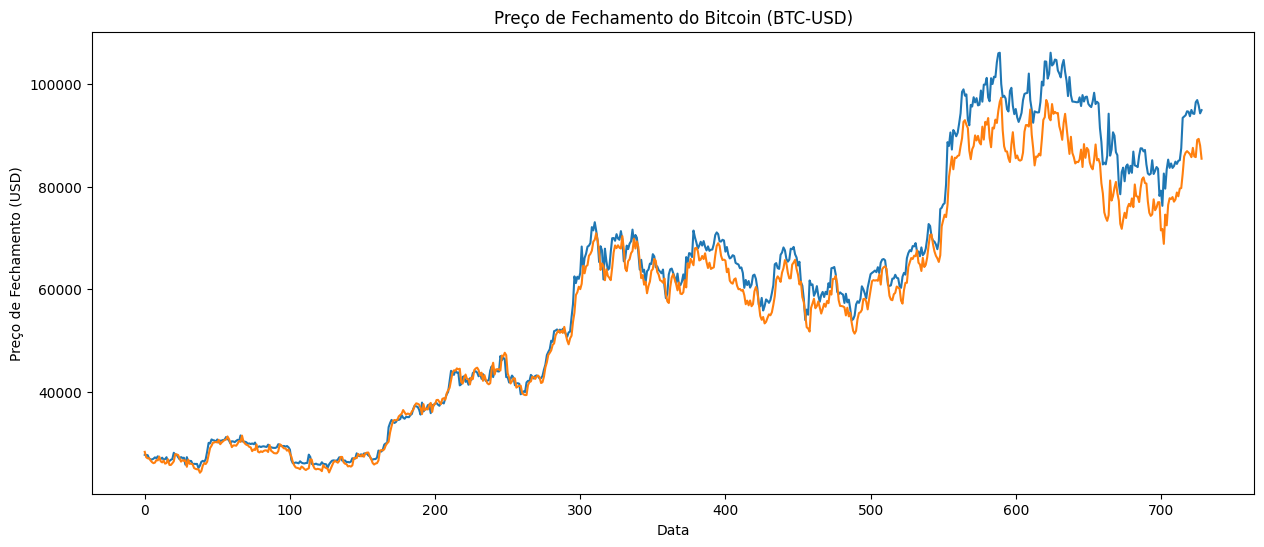

In [19]:
import matplotlib.pyplot as plt
# Plotando o preço de fechamento
plt.figure(figsize=(15,6))
plt.plot(y_true_inv)
plt.plot(y_pred_inv)

plt.title('Preço de Fechamento do Bitcoin (BTC-USD)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.show()

## Dados de Teste

In [20]:
import yfinance as yf

In [21]:
# Coleta dos dados
symbol = 'BTC-USD'
start_date = '2020-01-01'
end_date = '2025-07-17'
df_test = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [22]:
df_test.reset_index(inplace=True)

In [23]:
df_test.columns =['Date'	, 'Close'	,'High'	,'Low'	,'Open'	,'Volume']

In [24]:
# Gerar features e target
df_test = generate_features(df_test)

In [25]:
target_column = 'Close'
features = df.drop(['Date', 'Close'], axis=1).columns.tolist()

X_raw_test = df_test[features].copy()
y_raw_test = df_test[[target_column]].copy()

In [26]:
X_raw_test.set_index(df_test['Date'], inplace=True)
y_raw_test.set_index(df_test['Date'], inplace=True)

In [27]:
# ========================
# 2. Normalização
# ========================
X_scaled_test = scaler_X.transform(X_raw_test)
y_scaled_test = scaler_y.transform(y_raw_test)

In [28]:
# ========================
# 3. Criar janelas sequenciais
# ========================
window_size = 360
X_seq_test, y_seq_test = create_sequences(X_scaled_test, y_scaled_test, window_size)

In [29]:
test_loader = DataLoader(TimeSeriesDataset(X_seq_test, y_seq_test), batch_size=batch_size)

In [30]:
model.eval()
predictions_test = []
actuals_test = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        outputs = model(sequences).cpu().numpy()
        predictions_test.append(outputs)
        actuals_test.append(labels.numpy())

# Concatenar
y_pred_test = np.concatenate(predictions_test)
y_true_test = np.concatenate(actuals_test)

# Inverter normalização
y_pred_inv_test = scaler_y.inverse_transform(y_pred_test)
y_true_inv_test = scaler_y.inverse_transform(y_true_test)

In [31]:
# ========================
# 9. Métricas
# ========================
mae = mean_absolute_error(y_true_inv_test, y_pred_inv_test)
rmse = mean_squared_error(y_true_inv_test, y_pred_inv_test)
mape = mean_absolute_percentage_error(y_true_inv_test, y_pred_inv_test)

print(f"Avaliação do modelo:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")

Avaliação do modelo:
MAE  = 2601.6414
RMSE = 18749654.0000
MAPE = 4.02%


In [32]:
df_test_pred = pd.DataFrame()
df_test_pred['Date'] = df_test['Date'][window_size:].tolist()
df_test_pred['Close'] = df_test['Close'][window_size:].tolist()
df_test_pred['Close_pred'] = y_pred_inv_test

In [33]:
df_test_pred = df_test_pred[df_test_pred['Date']>='2025-06-01']

In [34]:
# ========================
# 9. Métricas
# ========================
mae = mean_absolute_error(df_test_pred['Close'], df_test_pred['Close_pred'])
rmse = mean_squared_error(df_test_pred['Close'], df_test_pred['Close_pred'])
mape = mean_absolute_percentage_error(df_test_pred['Close'], df_test_pred['Close_pred'])

print(f"Avaliação do modelo:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")

Avaliação do modelo:
MAE  = 12190.7485
RMSE = 153120496.1332
MAPE = 11.25%


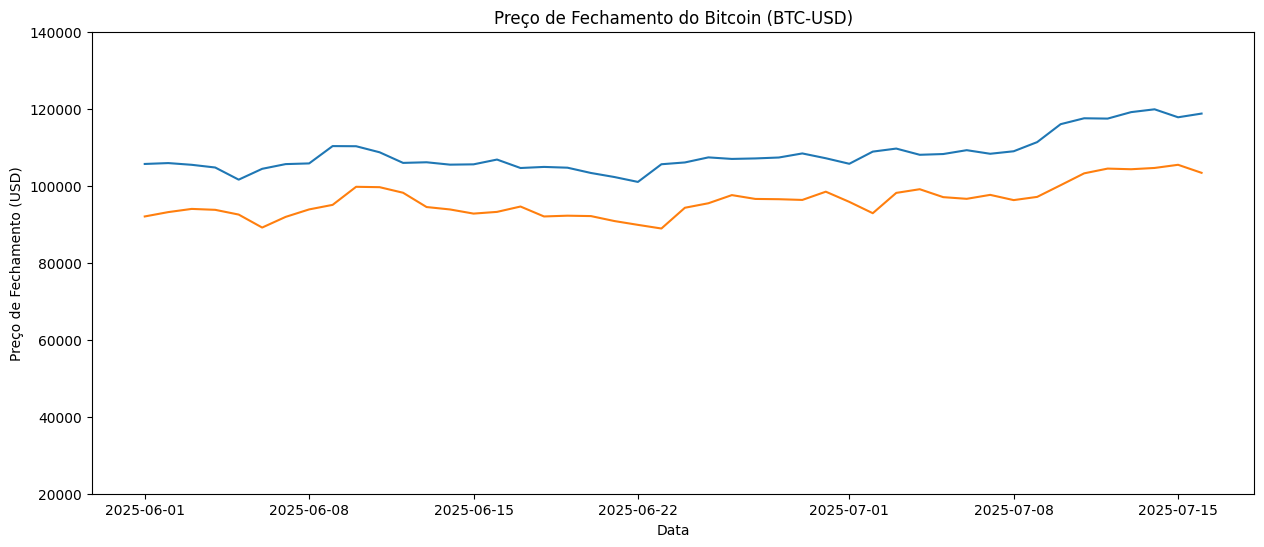

In [35]:
import matplotlib.pyplot as plt
# Plotando o preço de fechamento
plt.figure(figsize=(15,6))
plt.plot(df_test_pred['Date'], df_test_pred['Close'])
plt.plot(df_test_pred['Date'], df_test_pred['Close_pred'])

plt.title('Preço de Fechamento do Bitcoin (BTC-USD)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.ylim(20000, 140000)
plt.show()